# Neuralt Nettverk for bildegjennkjennign
Eirik Høydalsvik


## Motivasjon
Etter flere år med eksponering for AI igjennom media ble jeg innspirert til å lære mer om hvordan AI fungerer og implementere et neuralt nettverk. Prosjektet er basert på en videoserie av youtubekanalen 3Blue1Brown som forklarer matematikken bak neurale nettverk. 

In [13]:
import os,urllib.request
import codecs
import gzip
import shutil
import numpy as np
import pickle
import matplotlib.pyplot as pl

## Nedlasting
Minst datasettet er lagret med IDX filformatet som jeg var ukjent med før jeg startet prosjektet. Baserte meg på en kode laget av Ghosh4AI på youtube: https://www.youtube.com/watch?v=6xar6bxD80g og bruker biblioteket pickle for å lagre datasettene. 

In [14]:

# PROVIDE YOUR DOWNLOAD DIRECTORY HERE
datapath = '/../Data/'

# CREATING DOWNLOAD DIRECTORY
if not os.path.exists(datapath):
    os.makedirs(datapath)

# URLS TO DOWNLOAD FROM
urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

for url in urls:
    filename = url.split('/')[-1]   # GET FILENAME
    
    if os.path.exists(datapath+filename):
        print(filename, ' already exists')  # CHECK IF FILE EXISTS
    else:
        print('Downloading ',filename)
        urllib.request.urlretrieve (url, datapath+filename) # DOWNLOAD FILE
     
print('All files are available')




# LISTING ALL ARCHIVES IN THE DIRECTORY
files = os.listdir(datapath)
for file in files:
    if file.endswith('gz'):
        print('Extracting ',file)
        with gzip.open(datapath+file, 'rb') as f_in:
            with open(datapath+file.split('.')[0], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
print('Extraction Complete')

files = os.listdir(datapath)
def get_int(b):   # CONVERTS 4 BYTES TO A INT
    return int(codecs.encode(b, 'hex'), 16)

data_dict = {}
for file in files:
    if file.endswith('ubyte'):  # FOR ALL 'ubyte' FILES
        print('Reading ',file)
        with open (datapath+file,'rb') as f:
            data = f.read()
            type = get_int(data[:4])   # 0-3: THE MAGIC NUMBER TO WHETHER IMAGE OR LABEL
            length = get_int(data[4:8])  # 4-7: LENGTH OF THE ARRAY  (DIMENSION 0)
            if (type == 2051):
                category = 'images'
                num_rows = get_int(data[8:12])  # NUMBER OF ROWS  (DIMENSION 1)
                num_cols = get_int(data[12:16])  # NUMBER OF COLUMNS  (DIMENSION 2)
                parsed = np.frombuffer(data,dtype = np.uint8, offset = 16)  # READ THE PIXEL VALUES AS INTEGERS
                parsed = parsed.reshape(length,num_rows*num_cols)  # RESHAPE THE ARRAY AS [NO_OF_SAMPLES x HEIGHT x WIDTH]           
            elif(type == 2049):
                category = 'labels'
                temp = np.frombuffer(data, dtype=np.uint8, offset=8) # READ THE LABEL VALUES AS INTEGERS
                temp = temp.reshape(length)  # RESHAPE THE ARRAY AS [NO_OF_SAMPLES]
                parsed = np.zeros((len(temp),10))
                for i in range(len(temp)):
                    parsed[i][temp[i]] = 1
            if (length==10000):
                set = 'test'
            elif (length==60000):
                set = 'train'
            data_dict[set+'_'+category] = parsed  # SAVE THE np ARRAY TO A CORRESPONDING KEY


with open(datapath+'MNISTData.pkl', 'wb') as fp :
    pickle.dump(data_dict, fp)

train-images-idx3-ubyte.gz  already exists
train-labels-idx1-ubyte.gz  already exists
t10k-images-idx3-ubyte.gz  already exists
t10k-labels-idx1-ubyte.gz  already exists
All files are available
Extracting  t10k-images-idx3-ubyte.gz
Extracting  t10k-labels-idx1-ubyte.gz
Extracting  train-images-idx3-ubyte.gz
Extracting  train-labels-idx1-ubyte.gz
Extraction Complete
Reading  t10k-images-idx3-ubyte
Reading  t10k-labels-idx1-ubyte
Reading  train-images-idx3-ubyte
Reading  train-labels-idx1-ubyte


## Kode
Matematikken som ble presentert i videoene til 3Blue1Brown var skrevet for å være pedagogisk og ikke for å være lett å gjøre om til kode. Den første delen av prosjektet gikk dermed ut på å sitte med penn og papir og finne ut hvordan man implementerer gradient descent med numpy matriser (train() funksjonen). Dette var en krevende og interessang del av prosjektet hvor jeg fikk innsikt i hvordan AI fungerer.

In [45]:

datapath = '/../Data/'
with open(datapath+'MNISTData.pkl', 'rb') as fp :
    data_dict = pickle.load(fp)

#constants
h = .1
n = 100
randOffset = 0.5
randRange  = 1.
picSize = len(data_dict['train_images'][0])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#returns random weights and biaces 
def randWeights(shapeArr):
    wArr = []
    bVec = []
    for i in range(len(shapeArr)-1):
        wArr.append((np.random.rand(shapeArr[i+1], shapeArr[i]) - randOffset) * randRange) 
        bVec.append((np.random.rand(shapeArr[i+1]) - randOffset) * randRange)
    return wArr,bVec

#returns two lists of zero numpy arrays in the shape given by shapeArr
def zeroNabla(shapeArr):
    wArr = []
    bVec = []
    for i in range(len(shapeArr)-1):
        wArr.append(np.zeros((shapeArr[i+1], shapeArr[i])))
        bVec.append((np.zeros(shapeArr[i+1])))
    return wArr,bVec

#returns the guess given by the weights and biaces wArr and bVec
def guess(N,wArr,bVec,label):
    a = data_dict[label+'_images'][N]
    for i in range(len(wArr)):
        a = sigmoid(wArr[i] @ a + bVec[i])
    return a

#saves the weights and biaces
def save(wArr,bVec):
    pDict = {}
    pDict['w'] = wArr
    pDict['b'] = bVec
    with open(datapath+'pDict.pkl', 'wb') as fp :
        pickle.dump(pDict, fp)

#loads the weights and biaces
def load():
    with open(datapath+'pDict.pkl', 'rb') as fp :
        pDict = pickle.load(fp)
    return pDict['w'],pDict['b']

#tests given weights and biaces wArr and bVec on the 10 000 test_images and returns the proportion that where guessed correctly
def test(wArr,bVec):
    data = data_dict['test_images']
    labels = data_dict['test_labels']
    correct = 0
    for i in range(len(data)):
        c = np.argmax(labels[i])
        g = np.argmax(guess(i,wArr,bVec,'test'))
        if g == c:
            correct +=1
    return correct/len(data)

#picks random image from test dataset and shows the picture with the given guess
def show_guess():
    N = np.random.randint(0,len(data_dict['test_images']))
    A = data_dict['test_images'][N]
    A = np.reshape(A,(28,28))
    plt.imshow(A)
    print(np.argmax(guess(N,wArr,bVec,'test')))

#trains the given weights and biaces wArr and bVec on the train_images data set. Passes through the dataset N times
def train(wArr,bVec,shapeArr,N):
    data = data_dict['train_images']
    cost = data_dict['train_labels']

    wNabla, bNabla = zeroNabla(shapeArr)

    a = []
    a.append(data[0])
    for i in range(len(wArr)):
        a.append(sigmoid(wArr[i] @ a[i] + bVec[i]))
    
    count = 0
    trained = False
    while not trained:
        print("count",count)
        for i in range(len(data)):
            a[0] = data[i]
            for j in range(0,len(wArr)):
                a[j+1] = sigmoid(wArr[j] @ a[j] + bVec[j])

            c = 2 * (a[len(wArr)] - cost[i])
            for j in range(len(wArr),0,-1):
                wNabla[j - 1]  += np.outer(a[j]*(1-a[j]) * c, a[j-1] )
                bNabla[j - 1]  += a[j] * (1 - a[j]) * c
                c =  wArr[j - 1].T @ ((a[j] * (1-a[j]))*c)

            if i % n == 0:
                for i in range(len(wArr)):
                    wArr[i] -= h *  wNabla[i]/n
                    bVec[i] -= h *  bNabla[i]/n
                wNabla, bNabla = zeroNabla(shapeArr)
        count += 1

        if count == N:
            trained = True

shapeArr = [picSize,16,16,10]
wArr, bVec = randWeights(shapeArr)
train(wArr,bVec,shapeArr,10)
save(wArr,bVec)
print("andel av bilder gjettet riktig: " + str(test(wArr,bVec)))



count 0
count 1
count 2
count 3
count 4
count 5
count 6
count 7
count 8
count 9
andel av bilder gjettet riktig: 0.7611


2


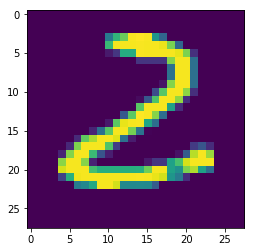

In [72]:
show_guess()